# Building an ensemble of future baseline scenarios
The scenario functions enable users to quickly generate scenarios by reassembling years from the historical data. Reusing past years can offer several advantages:
1. It is easier than creating boundary stresses from downscaled climate scenarios.
2. It is likely more accurate than ad-hoc models that may not accurately 
   capture the complex relationship between weather and groundwater stresses.
3. Past years are familiar and easier to communicate to stakeholders. For example: 
   "here is a scenario in which a water year like 2013 occurs three years in a row".
4. It is easy to generate an ensemble of scenarios.

This notebook will demonstrate how one can quickly and easily generate an ensemble
of scenarios that can be used as a baseline for a water management scenario. 

### 1 - Setup

In [ ]:
# IMPORT libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import flopy
from mfmodify import scenario_from_repeat_years, scenario_from_weighted_mean_of_years
from mfmodify.scenario import manual_reweight_series
from mfmodify.utils import get_idomain_df, annual_summary_from_gwf, add_new_hdobs

Point to the location of the existing historical model and the directory where we'll save scenarios.

In [2]:
# INPUT
sim_ws_orig = os.path.join('historic_models', 'model_v1-metric')
scenario_dir = os.path.join('scenario_tests', 'tvgwfm')
n_years = 10

Create a few functions 

In [3]:
def get_spaced_cells(node_cells, ncells):
    total_cells = len(node_cells)
    step = total_cells / ncells
    indices = np.round(np.arange(step/2, total_cells, step)).astype('int')
    spaced_cells = (
        node_cells
        .iloc[indices, :]
        .cellid.tolist()
    )
    return spaced_cells

def plot_ann_summary_bars(ann_df, figsize=(7.5, 10)):
    fig, axes = plt.subplots(ann_df.shape[1],1,figsize=figsize)
    for colname, ax in zip(ann_df.columns, axes):
        ann_df.loc[:, colname].plot(ax=ax, kind='bar', width=0.9, color='grey')
        ax.set_xlabel('')
        ax.set_ylabel(colname)
        ax.set_title(colname.split('_')[-1])
    fig.tight_layout()
    return fig

### 2. Create simple scenario from last years of historic period 
First we'll create a simple scenario (named 'base') by rerunning the final years of the historic period, using the final stress period of the historic solution as the initial condition. We'll add a few head observations spread around the model for comparisons. We'll also remove the oc file so the hds and bud files don't save.

In [4]:
# load the original gwf model to get the simulation years and to place hdobs
# get sim and gwf objects
sim_orig = flopy.mf6.MFSimulation.load(sim_ws=sim_ws_orig, verbosity_level=0)
gwf_orig = sim_orig.get_model()

In [5]:
# get an annual summary of the model years from the original model lst file
add_sum_orig = annual_summary_from_gwf(gwf_orig)
add_sum_orig.tail(n_years)

,total_recharge,total_discharge,net_storage
year,,,
2006,61121836.0,62957696.0,-1835857.50
2007,60412532.0,65279984.0,-4867452.00
2008,61004020.0,61700516.0,-696494.25
2009,64962272.0,61261284.0,3700987.50
2010,60769560.0,61920100.0,-1150543.25
2011,62719968.0,61779636.0,940331.00
2012,62824416.0,63705264.0,-880846.75
2013,59340544.0,68316424.0,-8975886.00
2014,65128788.0,66681316.0,-1552525.00


In [6]:
# get the model years and define the initial condition month and year
scen_years_base = add_sum_orig.index[-n_years:].values.tolist()
ic_mon_year = (12, scen_years_base[-1])
# set scenario directory name - calling this scenario 'base'
sim_ws_scenbase = os.path.join(scenario_dir, f'base-last_{n_years}_years')

We need the hds file to get the initial condition for the scenario. The .gitignore 
file ignores the large hds and bud files, so we need to run the original model. This 
example takes 2.5 minutes on my laptop.

In [7]:
sim_orig.run_simulation(silent=True)

(True, [])

Now we'll create the new simulation object, but we won't create files or run until 
after we add a hds and remove the oc file.

In [8]:
# make a scenario using the scenario builder function
sim_scen_base = scenario_from_repeat_years(
    sim_ws_orig, # original scenario directory
    scen_years_base, # the scenario years to assemble
    ic_mon_year, # year and month from original to use as initial conditions
    new_sim_ws=sim_ws_scenbase # new model file directory
)

Loading simulation from historic_models\model_v1-metric
generating new simulation with modified sp and timeseries info


In [9]:
# get gwf object
gwf_scen_base = sim_scen_base.get_model()
# remove oc
oc = gwf_scen_base.get_package('oc').remove()

For head observations, we'll just choose some equally spaced cells around the model

In [10]:
# get idomain locations as a dataframe (using helper function)
idomain_df = get_idomain_df(gwf_scen_base)
# get only active cells as options, let's stick to layer 1
cells_df = idomain_df.query('idomain==1').query('layer==1')
# choose evenly spaced cells (using helper function)
obs_cells = get_spaced_cells(cells_df, 6)
# make a hdobs continuous record
hdobs_continuous = {
    'hdobs.csv': 
    [[f'hdobs{i}', 'head', cellid] for i, cellid in enumerate(obs_cells)]
}
# add the new hdobs to the gwf object
add_new_hdobs(gwf_scen_base, hdobs_continuous)

package_name = hdobs
filename = mf6-tv_hist.head.obs
package_type = obs
model_or_simulation_package = model
model_name = mf6-tv_hist

Block options
--------------------
digits
{internal}
(5)


Block continuous
--------------------
continuous
{internal}
(rec.array([('hdobs0', 'head', (1, 26, 40), None),
           ('hdobs1', 'head', (1, 38, 45), None),
           ('hdobs2', 'head', (1, 44, 34), None),
           ('hdobs3', 'head', (1, 47, 57), None),
           ('hdobs4', 'head', (1, 51, 55), None),
           ('hdobs5', 'head', (1, 56, 43), None)],
          dtype=[('obsname', 'O'), ('obstype', 'O'), ('id', 'O'), ('id2', 'O')]))



Now we can write files and run the model. Takes about 1 minute on my laptop.

In [11]:
sim_scen_base.write_simulation(silent=True)
sim_scen_base.run_simulation(silent=True)

(True, [])

Some simple hdobs plots

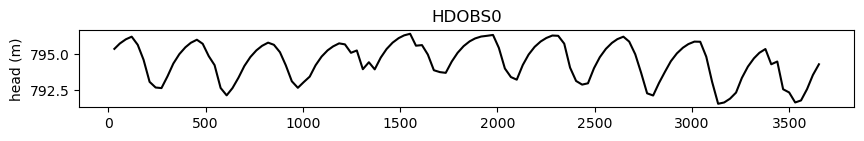

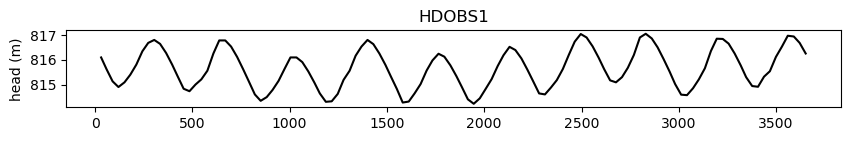

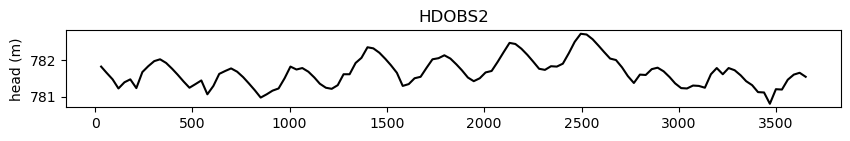

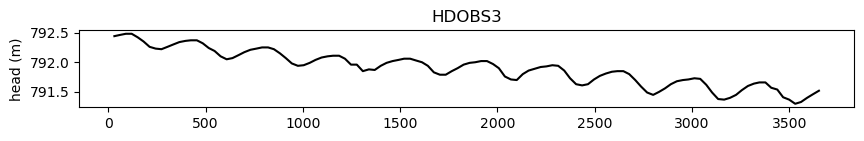

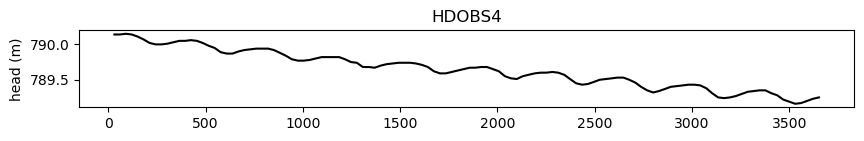

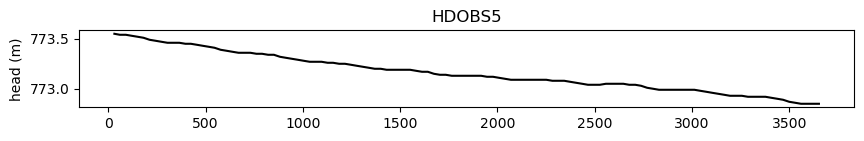

In [12]:
# load to dataframe
hdobs_out = os.path.join(sim_ws_scenbase, 'hdobs.csv')
hdobs_base_df = pd.read_csv(hdobs_out).set_index('time')
for obsnm in hdobs_base_df.columns:
    fig,ax = plt.subplots(1,1,figsize=(10,1))
    hdobs_base_df.loc[:, obsnm].plot(ax=ax, title=obsnm, color='black', label='base')
    ax.set_xlabel('')
    ax.set_ylabel('head (m)')

### 3. Look at historic years recharge, discharge, and storage
There is weather-driven variability in the recharge, discharge, and storage during the historic years.
We can pull the list file budget to look at the distribution of years in the entire historic period and the final years. This is informative and can also use this to construct scenario
that have a higher probability of wetness, dryness, or whatever if we wish to explore
climate-related impacts. 

In [22]:
# load the annual budget summary from list file (using helper function)
ann_scen_orig =annual_summary_from_gwf(gwf_orig)
ann_scen_orig.tail()

,total_recharge,total_discharge,net_storage
year,,,
2011,62719968.0,61779636.0,940331.00
2012,62824416.0,63705264.0,-880846.75
2013,59340544.0,68316424.0,-8975886.00
2014,65128788.0,66681316.0,-1552525.00
2015,63429836.0,66973404.0,-3543571.25


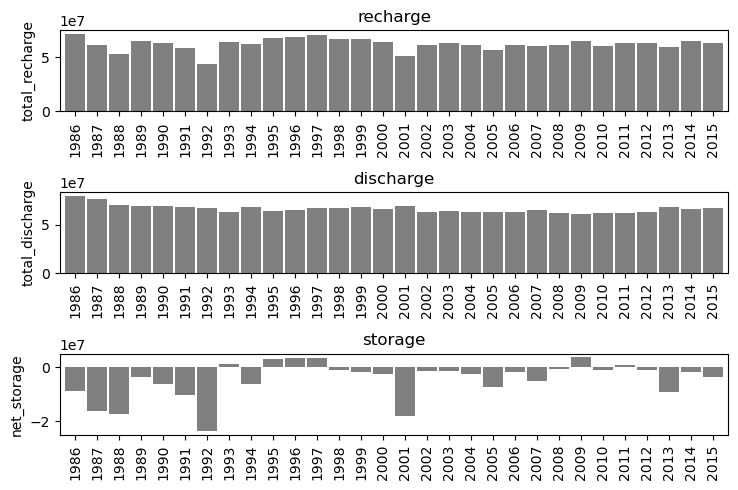

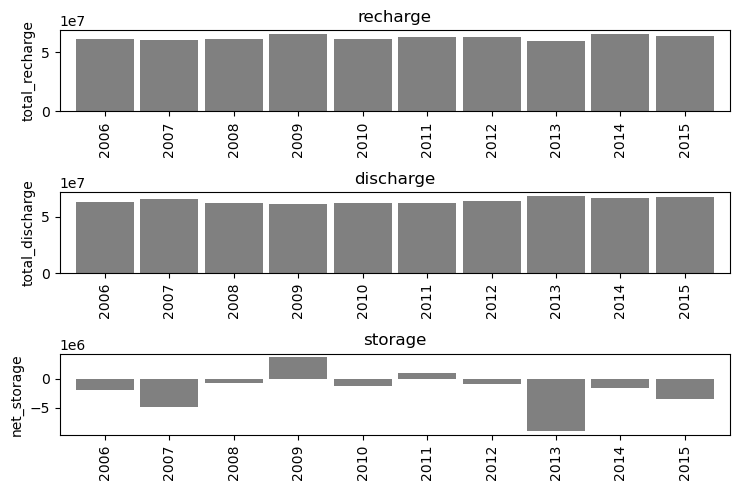

In [23]:
# plot for entire and final years
fig = plot_ann_summary_bars(ann_scen_orig, figsize=(7.5, 5))
fig = plot_ann_summary_bars(ann_scen_orig.iloc[-n_years:, :], figsize=(7.5, 5))

### 4. Create a scenario with 10 averaged 
This is a slight diversion just to show another mfmodify scenario function will 
create composite years as weighted averages of historic years. We'll just create 
a simulation that is the same length as the base above, but with the same averaged
repeated.

In [15]:
# Create a list of list of tuples to define the year weights. 
# Each inner list is a simulation year. The tuples in the list contain a year 
# and the relative weight of that year. All the years in the tuples for an inner 
# list item will be combined to create the inputs for that simulation year.
scen_years_and_weights = [[(yr, 1) for yr in scen_years_base]]*n_years
# create scenario object
sim_ws_scenavg = os.path.join(scenario_dir, f'base-avg_last_{n_years}_years')
sim_scenavg = scenario_from_weighted_mean_of_years(
    sim_ws_orig, 
    scen_years_and_weights,    
    ic_mon_year,
    new_sim_ws=sim_ws_scenavg
)
gwf_scenavg = sim_scenavg.get_model()
# add headobs using the hdobs continuous already made above
_ = add_new_hdobs(gwf_scenavg, hdobs_continuous)
# write and run
sim_scenavg.write_simulation()
sim_scenavg.run_simulation()

Loading simulation from historic_models\model_v1-metric
generating new simulation with modified sp and timeseries info
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package mf6-tv_hist...
  writing model mf6-tv_hist...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package sto...
    writing package oc...
    writing package ic...
    writing package drn_0...
    writing package drn_0_obs...
    writing package ghb-lowell...
    writing package ghb-lowell_obs...
    writing package nyriv...
    writing package nyriv_obs...
    writing package riv_0...
    writing package riv_0_obs...
    writing package wel-canal_a...
    writing package wel-canal_a_ts...
    writing package wel-canal_b...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 2367 based on size of stress_period_data
    writing package wel-canal_b_ts...
    writing package wel-infil_semi...
  

(True, [])

Let's look at the headobs alongside the base scenario. We can also plot an annual
summary to see that each year is the same.

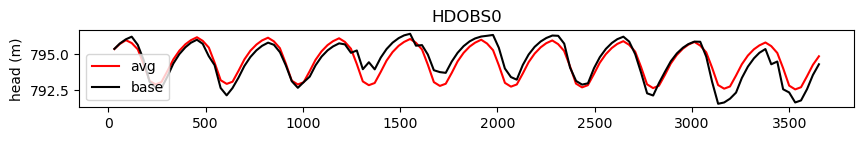

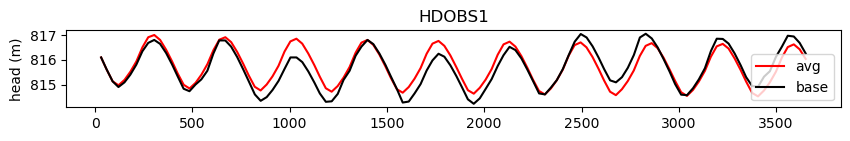

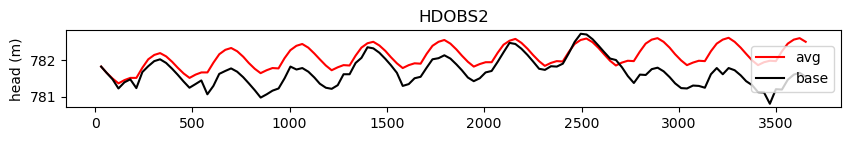

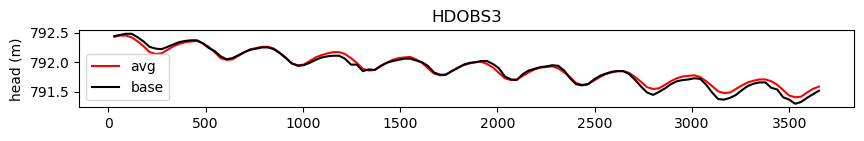

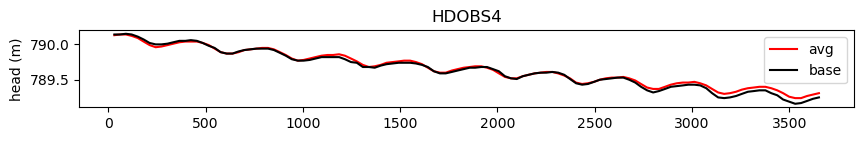

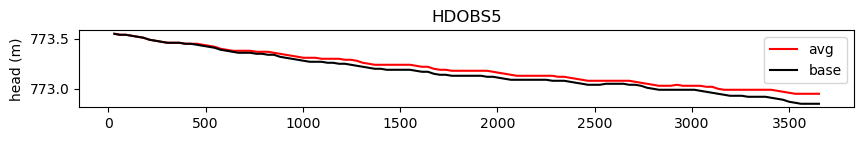

In [21]:
# Load headobs and plot with base
hdobs_out = os.path.join(sim_ws_scenavg, 'hdobs.csv')
hdobs_avg_df = pd.read_csv(hdobs_out).set_index('time')
# plot
for obsnm in hdobs_avg_df.columns:
    fig,ax = plt.subplots(1,1,figsize=(10,1))
    hdobs_avg_df.loc[:, obsnm].plot(ax=ax, color='red', label='avg')
    hdobs_base_df.loc[:, obsnm].plot(ax=ax, title=obsnm, color='black', label='base')
    ax.set_xlabel('')
    ax.set_ylabel('head (m)')
    ax.legend()

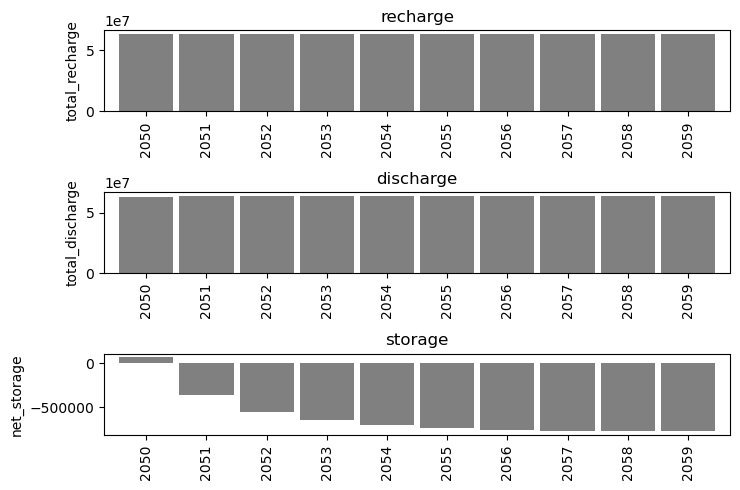

In [17]:
# load and plot annual summary
ann_scen_avg =annual_summary_from_gwf(gwf_scenavg)
fig = plot_ann_summary_bars(ann_scen_avg, figsize=(7.5, 5))

### 5. Run many randomly assembled scenarios
The years of the historic period can be randomly sampled to create scenarios with
different patterns of weather-driven recharge and discharge. We can sample with 
replacement and also adjust the relative probability of drawing wet/dry years. Below
we'll generate scenarios where the drier 1/2 of years are 2x as likely to occur than
they did historically.

Do weighted sampling simply by creating duplicates in the list of years

In [30]:
# get a series of final years annual summaries of storage as a proxy for wet/dry
ann_stor_orig = ann_scen_orig.iloc[-n_years:, :].net_storage
# set the desired relative weights of the years 
relative_weights = [2, 1]
# get list of years with duplicates to alter relative probabilities (helper function)
reweighted_years = (
    manual_reweight_series(ann_stor_orig, relative_weights)
    .sort_index()
    .index
    .to_list()
)
print(reweighted_years)

[2006, 2006, 2007, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2013, 2014, 2014, 2015, 2015]


Draw 10 random samples of years for scenarios

In [44]:
# Draw random samples 
from random import choices
scen_years_list = [choices(reweighted_years, k=n_years) for i in range(10)]
print(scen_years_list)

[[2008, 2014, 2014, 2012, 2011, 2006, 2008, 2006, 2015, 2012], [2007, 2008, 2010, 2008, 2009, 2008, 2014, 2007, 2006, 2010], [2012, 2012, 2006, 2006, 2009, 2010, 2009, 2014, 2014, 2006], [2006, 2015, 2007, 2015, 2007, 2007, 2015, 2015, 2013, 2013], [2013, 2006, 2014, 2014, 2014, 2014, 2011, 2006, 2014, 2013], [2012, 2012, 2014, 2015, 2014, 2009, 2013, 2013, 2015, 2013], [2014, 2012, 2009, 2010, 2013, 2010, 2014, 2011, 2010, 2013], [2013, 2006, 2014, 2013, 2011, 2015, 2012, 2013, 2014, 2006], [2011, 2007, 2013, 2014, 2013, 2006, 2015, 2007, 2012, 2008], [2013, 2013, 2008, 2014, 2007, 2006, 2013, 2006, 2015, 2009]]


Create and run all 10 scenarios. This takes about 16 minutes on my laptop.

In [46]:
# Loop over all lists of years
for i, iscen_years in enumerate(scen_years_list):
    isim_ws = os.path.join(scenario_dir, f'rand_{n_years}_years_{i}')
    isim_scen = scenario_from_repeat_years(
        sim_ws_orig, 
        iscen_years,
        ic_mon_year,
        new_sim_ws=isim_ws
    )
    igwf_scen = isim_scen.get_model()
    # add headobs using the hdobs continuous already made above
    _ = add_new_hdobs(igwf_scen, hdobs_continuous)
    # write and run
    isim_scen.write_simulation()
    isim_scen.run_simulation()

Loading simulation from historic_models\model_v1-metric
generating new simulation with modified sp and timeseries info
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package mf6-tv_hist...
  writing model mf6-tv_hist...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package sto...
    writing package oc...
    writing package ic...
    writing package drn_0...
    writing package drn_0_obs...
    writing package ghb-lowell...
    writing package ghb-lowell_obs...
    writing package nyriv...
    writing package nyriv_obs...
    writing package riv_0...
    writing package riv_0_obs...
    writing package wel-canal_a...
    writing package wel-canal_a_ts...
    writing package wel-canal_b...
    writing package wel-canal_b_ts...
    writing package wel-infil_semi...
    writing package wel-infil_semi_ts...
    writing package wel-infil_irr...
    writing package wel-infil_i

Load and plot all of the headobs together

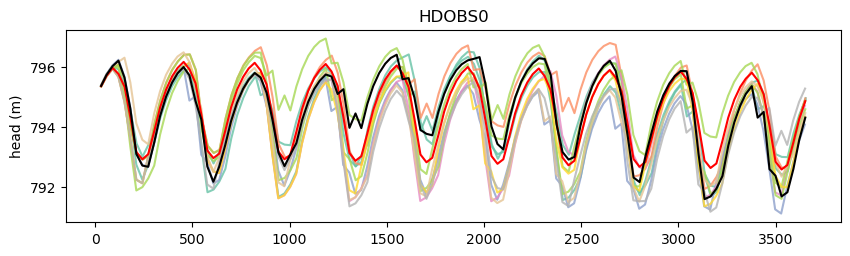

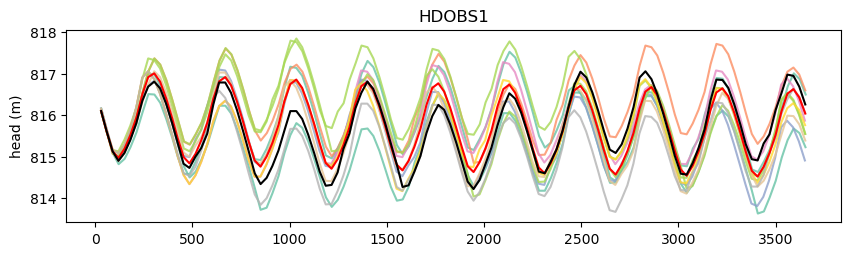

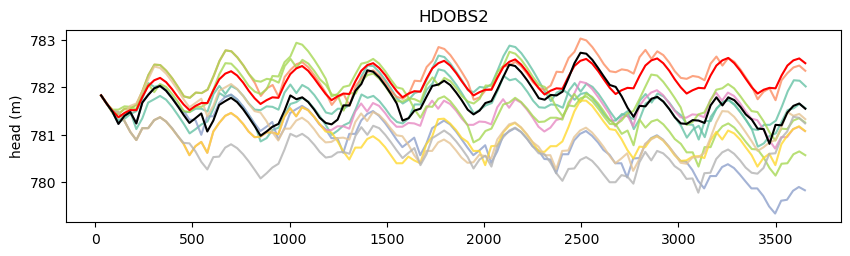

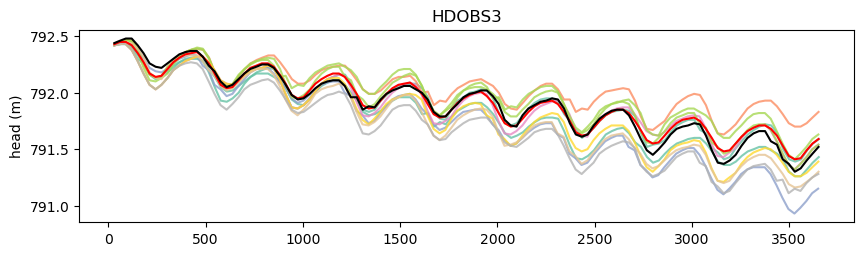

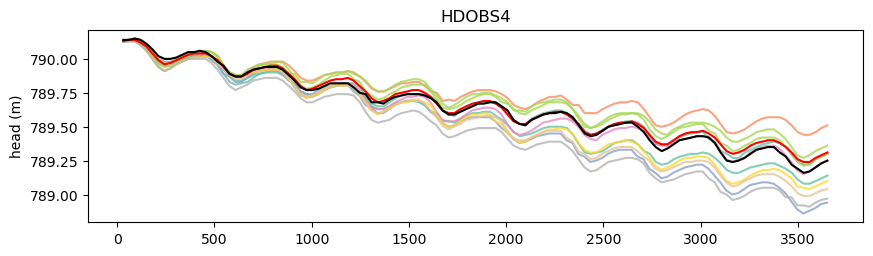

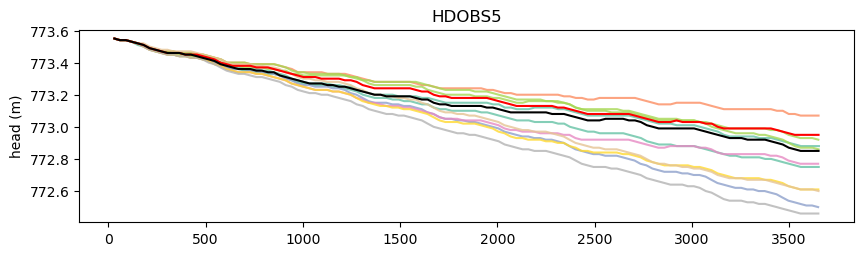

In [58]:
# Load headobs and plot with base
hdobs_df_list = []
for i in range(10):
    isim_ws = os.path.join(scenario_dir, f'rand_{n_years}_years_{i}')
    ihdobs_out = os.path.join(isim_ws, 'hdobs.csv')
    ihdobs_avg_df = pd.read_csv(ihdobs_out).set_index('time')
    hdobs_df_list.append(ihdobs_avg_df)
# plot
cmap = plt.get_cmap('Set2')
colors = [cmap(i/len(hdobs_df_list)) for i in range(len(hdobs_df_list))]
for obsnm in hdobs_avg_df.columns:
    fig,ax = plt.subplots(1,1,figsize=(10,2.5))
    for i, ihdobs_df in enumerate(hdobs_df_list):
        ihdobs_df.loc[:, obsnm].plot(ax=ax, label=None, color=colors[i], alpha=0.8)
    hdobs_avg_df.loc[:, obsnm].plot(ax=ax, color='red', label='avg')
    hdobs_base_df.loc[:, obsnm].plot(ax=ax, title=obsnm, color='black', label='base')
    ax.set_xlabel('')
    ax.set_ylabel('head (m)')